In [1]:
from ncempy.io import dm
import numpy as np
from math import *
from matplotlib import pyplot,colors
from skimage.restoration import denoise_tv_chambolle
from scipy import ndimage, signal
import os
from pyevtk.hl import imageToVTK
from ipywidgets import interact, interactive
from scipy import ndimage, signal, interpolate

In [2]:
folder = "Diffraction-tilt-Serises/213phase-(-40 to 40) Tilt/"
flist = [f for f in os.listdir(folder) if "b2" in f]

In [3]:
data = np.zeros((41,1024,1024))
for i in range(41):
    if '25.dm3' in flist[i]:
        data[i] = dm.dmReader(folder+flist[i])['data']
    else:
        data[i] = dm.dmReader(folder+flist[i])['data'].sum(0)/5.

In [4]:
data[data<10]=10

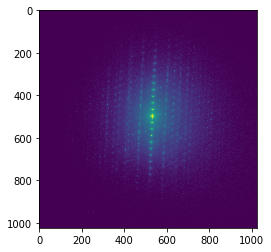

In [5]:
pyplot.imshow(data.sum(0), norm=colors.LogNorm(), interpolation='none')

2.3599999999999968


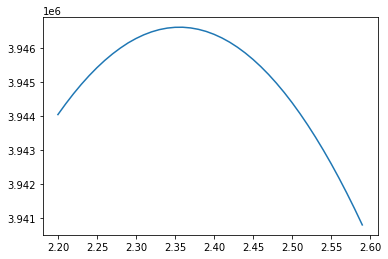

In [6]:
std_arr=[]
angles= np.arange(2.2,2.6,0.01)

datasum=data.sum(0)

for iangle in angles:
    std_arr += [ndimage.rotate(datasum, angle=iangle, reshape=False).sum(0).std()]
pyplot.plot(angles, std_arr)

print(angles[np.array(std_arr).argmax()])

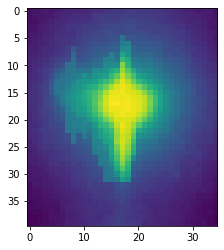

In [7]:
pyplot.imshow(data.sum(0)[480:520,515:550], norm=colors.LogNorm(), interpolation='none')

In [8]:
# A simple test to figure out the shift between images
def cross_correlation(im1, im2):
    im1_2 = im1 - im1.mean()
    im2_2 = im2 - im2.mean()
    ccl = signal.fftconvolve(im1_2, im2_2[::-1,::-1], mode='same')

    dy, dx = np.unravel_index(np.argmax(ccl), im2.shape)
    dy -= im2.shape[0]/2.
    dx -= im2.shape[1]/2.
    return dy, dx

for i in range(1,41):
    dy, dx = cross_correlation(data[0,480:520,510:545], data[i,480:520,510:545])
    print("{0}: found shift {1} in y and {2} in x".format(i, dy, dx))
    dy = int(round(dy,0))
    dx = int(round(dx,0))
    data[i] = np.roll(data[i], (dy,dx), axis=(0,1))

# this corrects the drift with regard to the first image
# for continuous and large drift, you might want to modify it so that each image corrects with regard to the previous one

1: found shift 0.0 in y and 0.5 in x
2: found shift 0.0 in y and -0.5 in x
3: found shift 0.0 in y and -0.5 in x
4: found shift 0.0 in y and -0.5 in x
5: found shift 0.0 in y and 0.5 in x
6: found shift 0.0 in y and 0.5 in x
7: found shift 0.0 in y and 0.5 in x
8: found shift 0.0 in y and 0.5 in x
9: found shift 0.0 in y and 0.5 in x
10: found shift 0.0 in y and 0.5 in x
11: found shift 0.0 in y and 0.5 in x
12: found shift 0.0 in y and 0.5 in x
13: found shift 0.0 in y and 0.5 in x
14: found shift 0.0 in y and 1.5 in x
15: found shift 0.0 in y and 0.5 in x
16: found shift 0.0 in y and 1.5 in x
17: found shift 0.0 in y and 1.5 in x
18: found shift 0.0 in y and 1.5 in x
19: found shift 0.0 in y and 1.5 in x
20: found shift 3.0 in y and 10.5 in x
21: found shift 1.0 in y and 8.5 in x
22: found shift 1.0 in y and 5.5 in x
23: found shift 0.0 in y and 4.5 in x
24: found shift 0.0 in y and 3.5 in x
25: found shift 0.0 in y and 2.5 in x
26: found shift 0.0 in y and 2.5 in x
27: found shift 0

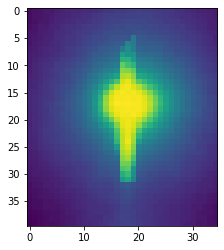

In [9]:
pyplot.imshow(data.sum(0)[480:520,515:550], norm=colors.LogNorm(), interpolation='none')

In [10]:
data_flat = np.copy(data)
for i in range(41):
    data_flat[i] /= (ndimage.gaussian_filter(data[i],80)/2+50)

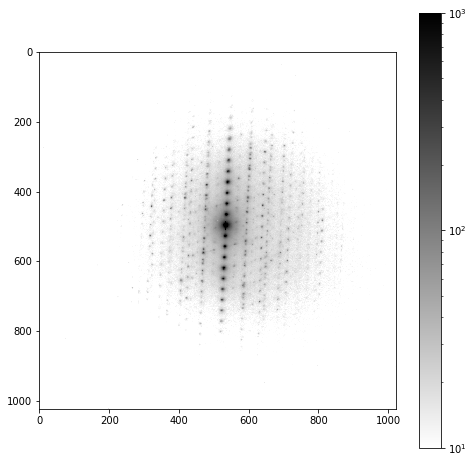

In [11]:
f, ax = pyplot.subplots(figsize=(8,8))
im=ax.imshow(data_flat.sum(0), norm=colors.LogNorm(vmin=10, vmax=1000), interpolation='none', cmap='binary')
pyplot.colorbar(im)

In [12]:
# center X is 533 

data_interp = np.zeros(data.shape)

x = np.arange(1024)-533
y = np.arange(1024)
xx, yy = np.meshgrid(x,y)

for i in range(0,21):
    f = interpolate.interp2d(x*np.cos(np.radians((i-21)*2)),y,data_flat[i], kind='cubic', fill_value=0)
    data_interp[i] = f(x,y)
    
for i in range(22,41):
    f = interpolate.interp2d(x*np.cos(np.radians((i-21)*2)),y,data_flat[i], kind='cubic', fill_value=0)
    data_interp[i] = f(x,y) 
    
data_interp[21] = np.copy(data_flat[21])

In [13]:
data_rot = ndimage.rotate(data_interp.sum(0), angle=2.35, reshape=False)

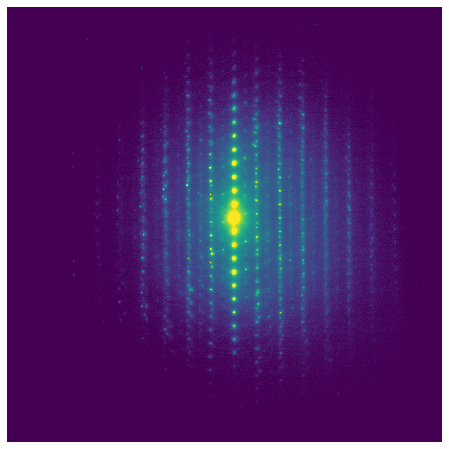

In [14]:
f, ax = pyplot.subplots(figsize=(8,8))
ax.imshow(data_rot[20:-20,20:-20], norm=colors.LogNorm(vmin=8,vmax=200), interpolation='none', cmap='viridis')
ax.set_axis_off()
#pyplot.savefig("projection_8_200_viridis.png", dpi=300)